In [2]:
%pylab inline

import os
import logging
import time
import asyncio
import datetime
import glob
from pprint import pprint

import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
import pandas as pd
import h5py

from sipyco.pc_rpc import (Client, AsyncioClient,
                           BestEffortClient, AutoTarget)
from artiq.master.databases import DeviceDB
from artiq.master.worker_db import DeviceManager

Populating the interactive namespace from numpy and matplotlib


In [3]:
# let's assume artiq_master and artiq_ctlmgr are already running
# then move to a location where we have our artiq setup
os.chdir(os.path.expanduser("~/work/nist/artiq/run"))

In [4]:
# we can directly use the artiq controller infrastructure
# and access any artiq device

# we can have artiq prepare that connection for us:
ddb = DeviceDB("device_db.py")
devmgr = DeviceManager(ddb)
lda = devmgr.get("lda")
lda.set_attenuation(42)
assert lda.get_attenuation() == 42

# ... or we can wire it up ourselves if you know where it is
assert ddb.get("lda", resolve_alias=True)["host"] == "::1"
assert ddb.get("lda", resolve_alias=True)["port"] == 3253

# there are different Client types tailored to different use cases:

# synchronous
lda = Client("::1", 3253)
assert lda.get_attenuation() == 42

# asyncio
lda = AsyncioClient()
async def test_lda():
    await lda.connect_rpc("::1", 3253, AutoTarget)
    return await lda.get_attenuation()
assert asyncio.get_event_loop().run_until_complete(test_lda()) == 42

# best effort
lda = BestEffortClient("::1", 3253, AutoTarget)
assert lda.get_attenuation() == 42

In [5]:
# let's connect to the master

schedule, exps, datasets = [
    Client("::1", 3251, "master_" + i) for i in
    "schedule experiment_db dataset_db".split()]

print("current schedule")
pprint(schedule.get_status())
print("experiments:")
pprint(exps.list_directory("repository"))

current schedule
{}
experiments:
['ex/',
 'test_analyzer.py',
 'notebook_test.py',
 'speed_benchmark.py',
 'histograms.py',
 'arguments_demo.py',
 '.git/',
 '__pycache__/',
 'flopping_f_simulation.py',
 'test_crash.py',
 'run_forever.py',
 'transport.py',
 'pdq2_simple.py']


In [6]:
# we can submit experiments to be run

expid = dict(
    file="repository/flopping_f_simulation.py",
    class_name="FloppingF",
    log_level=logging.WARNING,
    arguments=dict(
        F0=1500,
        noise_amplitude=.3,
    ),
)
if not schedule.get_status():
    rid = schedule.submit(pipeline_name="main", expid=expid,
        priority=0, due_date=None, flush=False)
print("current schedule")
pprint(schedule.get_status())

current schedule
{4722: {'due_date': None,
        'expid': {'arguments': {'F0': 1500, 'noise_amplitude': 0.3},
                  'class_name': 'FloppingF',
                  'file': 'repository/flopping_f_simulation.py',
                  'log_level': 30},
        'flush': False,
        'pipeline': 'main',
        'priority': 0,
        'repo_msg': None,
        'status': 'preparing'}}


In [7]:
# wait for experiment to finish
# this can be written nicer by subscribing and reacting to scheduler changes
while rid in schedule.get_status():
    time.sleep(.1)

flopping_f: 1499.944285221012


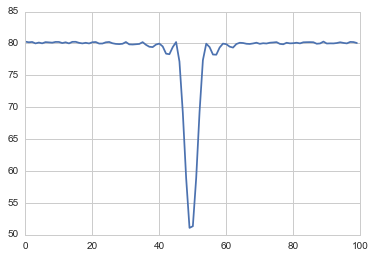

In [8]:
# now that the experiment has completed, we can get the
# current value of the (live) dataset and plot it
# had we done this earlier, the dataset would have been incomplete
fig, ax = plt.subplots()
d = datasets.get("flopping_f_brightness")
ax.plot(d)
print("flopping_f:", datasets.get("flopping_freq"))

In [9]:
# this is how you would clear all pipelines
for i in schedule.get_status():
    schedule.delete(i)

In [10]:
# we can easily find and use the data that was saved as part
# of the experiment

t = datetime.datetime.now()
f = os.path.join(
    "results", t.strftime("%Y-%m-%d"), #t.strftime("%H-%M"),
    "*", "{:09d}-FloppingF.h5".format(rid))

# we would usually like to use pandas but our data does not have
# the metadata pandas want
#d = pd.HDFStore(glob.glob(f)[0])

with h5py.File(glob.glob(f)[0]) as f:
    print("available datasets", list(f))
    assert np.allclose(f["datasets/flopping_f_brightness"], d)

available datasets ['artiq_version', 'flopping_f_brightness']


In [11]:
%%writefile repository/notebook_test.py

# we can also write experiments in the notebook and submit them
# we don't have submit-by-content yet (and there would be questions
# about other modules that would need to be imported) so we just export
# this cell and submit it by filename

from artiq.experiment import *

class Hello(EnvExperiment):
    def build(self):
        pass
    
    def run(self):
        print("Hello world!")

Overwriting repository/notebook_test.py


In [12]:
expid = dict(
    file="repository/notebook_test.py",
    class_name="Hello",
    log_level=logging.WARNING,
    arguments=dict(),
)
rid = schedule.submit(pipeline_name="misc", expid=expid,
    priority=1, due_date=None, flush=False)
print(rid)
# on the master you should see the message.

4724
